In [9]:
%matplotlib inline
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

import numpy as np
import pandas as pd

from collections import defaultdict
from sklearn.model_selection import train_test_split

In [10]:
original_data = pd.read_csv('../data/pedalboard-plugin.csv', sep=",", index_col=['id', 'name'])
original_data.head()

plugin1  plugin2  plugin3  plugin4  plugin5  plugin6
id    name                                                            
9467  !!*Cuda'         23       27       73      109      106       61
7313  '70s*V.H**       39       30      100       60      107      107
      '90s*V.H**       23       99       31       42       53       60
9467  *!!*Wanted       23       27       85       49       60      107
10849 **********      107      107      107      107      107       84

In [11]:
categories_data = pd.read_csv('../data/plugins_categories_simplified.csv', sep=",")
categories_data.head()

def category(index):
    return categories_data[categories_data['id'] == index]['category'].values[0]

# KNN

In [12]:
def distance(a, b):
    return sum([0 if a == b else 1 for (a, b) in zip(a, b)])

In [13]:
class KNNMeasure(object):
    
    def __init__(self, train, k):
        self.train = train
        self.columns = [f'plugin{i}' for i in range(1, self.number_columns+1)]
        self.nbrs = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='hamming').fit(self.train)

    @property
    def number_columns(self):
        return self.train.shape[1]

    def _generate_log(self):
        columns = self.columns + ['mean']
        
        data = {column: np.zeros(1) for column in columns}
        return pd.DataFrame(data=data)

    def evaluate(self, test):
        log = self._generate_log()
        
        for column in self.columns:
            evaluation = self.evaluate_column(column, test)
            log.iloc[0][column] = evaluation

        log['mean'] = log[self.columns].T.mean()
        return log

    def evaluate_column(self, column, test_data_original):
        test = test_data_original.copy()
        test[column] = -1

        distances, indices = self.nbrs.kneighbors(test)
        
        return self.count_hits(column, indices, test_data_original) / len(test)
        
    def count_hits(self, column, indices_patches_suggestions, test):
        patches_evaluated = 0
        
        for index_patch_test, indices in enumerate(indices_patches_suggestions):
            element = test.iloc[index_patch_test][column]
            suggestions = self.train.iloc[indices][column].values

            if element in suggestions:
                patches_evaluated += 1

        return patches_evaluated


In [14]:
def evaluate(original_data, k):
    data = shuffle(original_data, random_state=42)
    kfold = KFold(n_splits=5, random_state=42, shuffle=False)

    results = []

    for i, (train_index, test_index) in enumerate(kfold.split(data)):
        print(i)
        training = data.iloc[train_index]
        test = data.iloc[test_index]

        results.append(KNNMeasure(training, k=k).evaluate(test))

    evaluation = pd.concat(results)
    evaluation['k'] = k
    
    return evaluation

evaluation = pd.concat([evaluate(original_data, k=k) for k in (1, 5)])
evaluation

0
1
2
3
4
0
1
2
3
4


,plugin1,plugin2,plugin3,plugin4,plugin5,plugin6,mean,k
0,0.400000,0.168421,0.155263,0.207895,0.292105,0.507895,0.288596,1
0,0.363158,0.202632,0.189474,0.257895,0.350000,0.534211,0.316228,1
0,0.394737,0.234211,0.189474,0.234211,0.365789,0.497368,0.319298,1
0,0.389474,0.250000,0.192105,0.257895,0.336842,0.489474,0.319298,1
0,0.374670,0.240106,0.187335,0.287599,0.356201,0.522427,0.328056,1
0,0.615789,0.360526,0.339474,0.389474,0.515789,0.681579,0.483772,5
0,0.560526,0.368421,0.381579,0.457895,0.544737,0.710526,0.503947,5
0,0.631579,0.397368,0.368421,0.439474,0.521053,0.684211,0.507018,5
0,0.610526,0.365789,0.355263,0.473684,0.547368,0.697368,0.508333,5
0,0.593668,0.387863,0.377309,0.472296,0.546174,0.699208,0.512753,5


In [15]:
evaluation.to_csv('knn_evaluation.csv')

In [16]:
evaluation_final = pd.concat([evaluation.groupby('k').mean()['mean'], evaluation.groupby('k')['mean'].std()], axis=1)
evaluation_final.columns = ['mean', 'std']
evaluation_final

,mean,std
k,,
1,0.314295,0.015030
5,0.503165,0.011294


# Test something

In [ ]:
class InspectSomething(object):
    '''
    Not used now
    '''
    def __init__(self, number_elements=117):
        self.hits_by_plugins = pd.DataFrame(data={f'plugin{i+1}': np.zeros(number_elements) for i in range(number_columns)})
        self.hits_by_categories = pd.DataFrame(data={f'plugin{i+1}': np.zeros(number_elements) for i in range(number_columns)})

    def inspect(self, element, suggestions):
        if element in suggestions:
            self.hits_by_plugins[column][element] += 1

        elif category(element) in [category(e) for e in suggestions]:
            self.hits_by_categories[column][element] += 1

In [3]:
total = pd.DataFrame(data={
    f'plugin{i}': original_data[f'plugin{i}'].value_counts()
    for i in range(1, 7)
}).fillna(0)

total.head(5)

,plugin1,plugin2,plugin3,plugin4,plugin5,plugin6
0,4.0,3.0,5.0,0.0,1.0,0.0
1,8.0,6.0,13.0,3.0,0.0,1.0
2,3.0,12.0,3.0,0.0,1.0,0.0
3,0.0,6.0,4.0,2.0,1.0,2.0
4,0.0,4.0,1.0,7.0,13.0,0.0


In [4]:
frequencies = total / total.sum()

frequencies.head(5)

,plugin1,plugin2,plugin3,plugin4,plugin5,plugin6
0,0.002106,0.001580,0.002633,0.000000,0.000527,0.000000
1,0.004213,0.003160,0.006846,0.001580,0.000000,0.000527
2,0.001580,0.006319,0.001580,0.000000,0.000527,0.000000
3,0.000000,0.003160,0.002106,0.001053,0.000527,0.001053
4,0.000000,0.002106,0.000527,0.003686,0.006846,0.000000


# Inspect hits by plugin

In [63]:
from functools import reduce

def hits_mean(hits):
    return reduce(lambda a, b: a+b, hits[1:], hits[0]) / len(hits)

hits_kfolds_k1_mean = hits_mean(hits_kfolds_k1)
hits_kfolds_k5_mean = hits_mean(hits_kfolds_k5)

hits_kfolds_k1_category_mean = hits_mean(hits_kfolds_k1_categories)
hits_kfolds_k5_category_mean = hits_mean(hits_kfolds_k5_categories)

In [50]:
def split(x, steps):
    summation = x.sum()
    
    step_size = summation/(steps*1.)
    cumsum = x.cumsum()

    k_minus_1 = [x[(step_size*i < cumsum) & (cumsum <= (step_size*(i+1)))] for i in range(steps-1)]
    k_th = [x[step_size*(steps-1) < cumsum]]

    return k_minus_1 + k_th

In [51]:
def range_accuracy(column, hits, total, k=4):
    hits = hits[column]
    total = total[column]
    
    totals = []
    for part in split(total.sort_values(), k):
        totals.append(hits.iloc[part.index].sum() / part.sum())

    return pd.Series(totals, name=column)

/home/paulo/git/RBM/venv/lib/python3.6/site-packages/ipykernel-5.1.0-py3.6.egg/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c1e980588>,
      dtype=object)

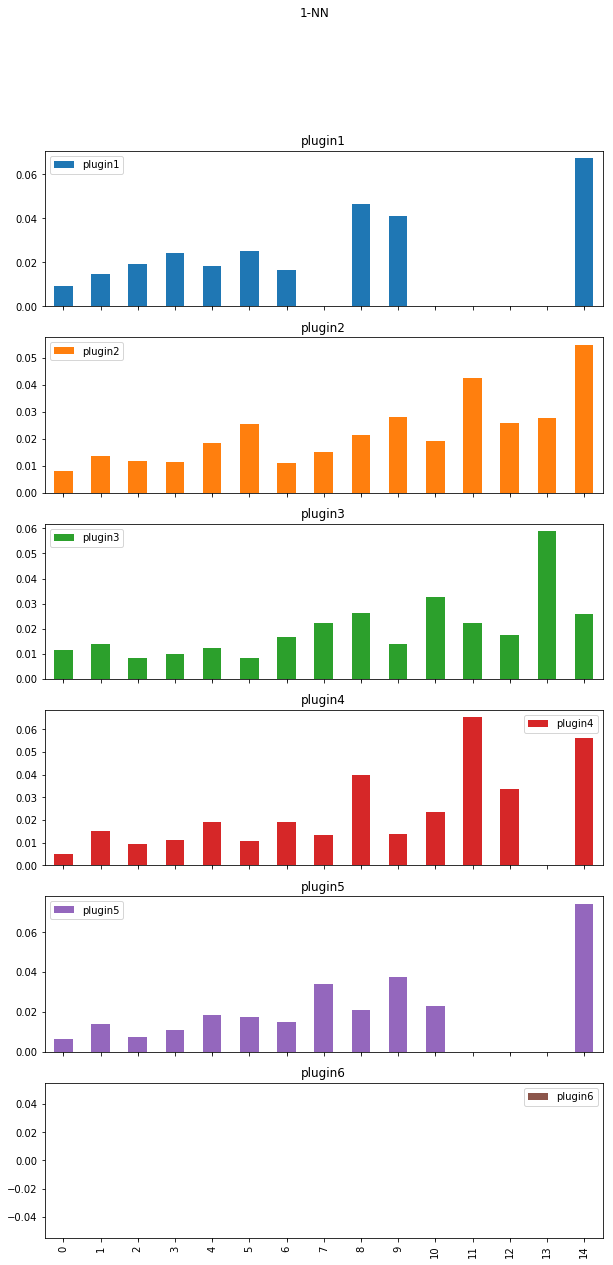

In [52]:
k1_result = pd.DataFrame({
    f'plugin{i}': range_accuracy(f'plugin{i}', hits_kfolds_k1_mean, total, k=15)
    for i in range(1, 7)
})
#k1_result.plot.bar(title="1-NN", subplots=True, figsize=(10, 20))
#(k1_result/k1_result.sum()).plot.bar(title="1-NN", subplots=True, figsize=(10, 20))
k1_result.plot.bar(title="1-NN", subplots=True, figsize=(10, 20))

/home/paulo/git/RBM/venv/lib/python3.6/site-packages/ipykernel-5.1.0-py3.6.egg/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3ec3c36eb8>,
      dtype=object)

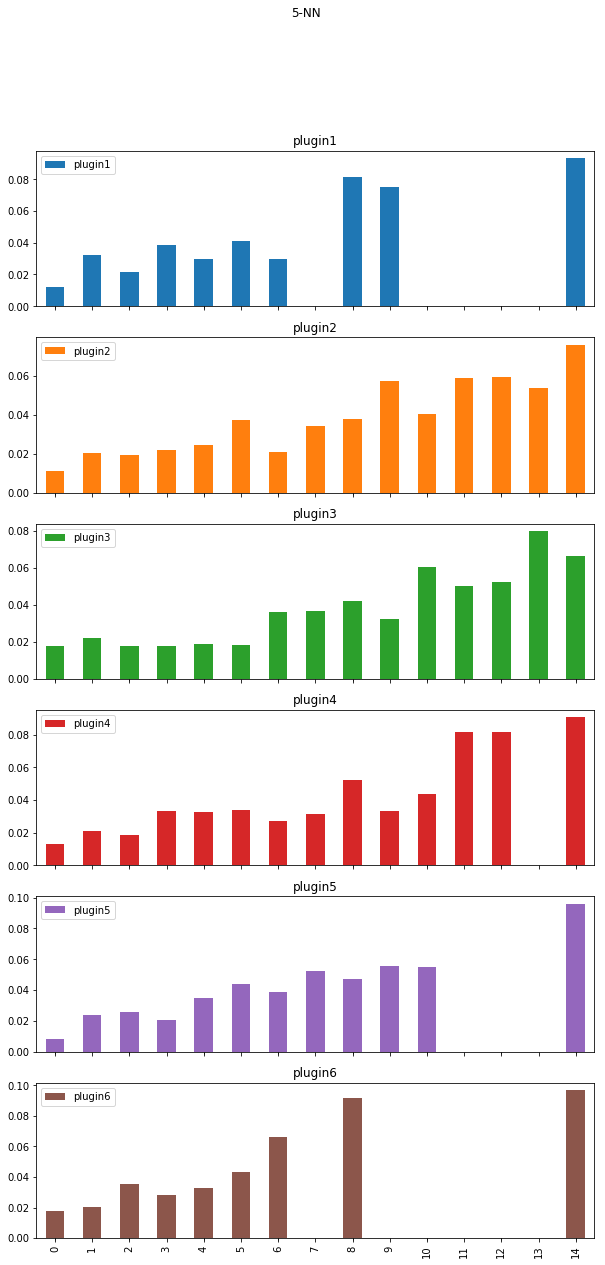

In [443]:
k5_result = pd.DataFrame({
    f'plugin{i}': range_accuracy(f'plugin{i}', hits_kfolds_k5_mean, total, k=15)
    for i in range(1, 7)
})
k5_result.plot.bar(title="5-NN", subplots=True, figsize=(10, 20))

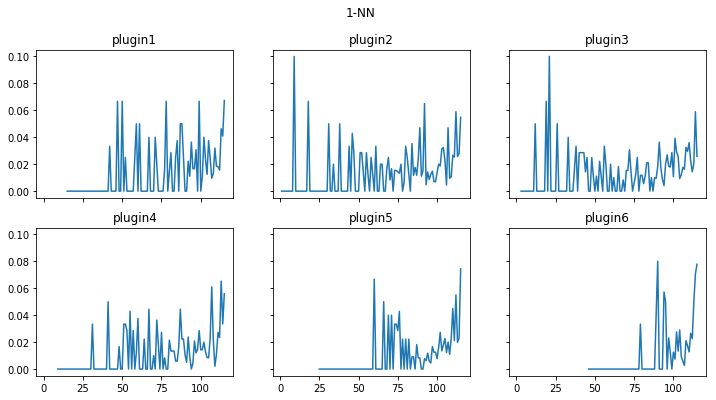

In [523]:
import matplotlib.pyplot as plt

#hits_kfolds_k5_mean['plugin1']
#range_accuracy(f'plugin{i}', hits_kfolds_k1_mean, total, k=15)

def individual_accuracy(total, evaluated, title):
    fig, axes = plt.subplots(2, 3, sharex=True, sharey=True)
    fig.suptitle(title)
    
    #fig.set_ylabel('Undamped')

    for i, ax in zip(range(1, 7), axes.reshape(-1)):
        column = f'plugin{i}'

        #indices = total[column][total[column] != 0].sort_values().index
        indices = total[column].sort_values().index

        (evaluated[column] / total[column]).iloc[indices].to_frame().reset_index()[column].plot(title=column, ax=ax, figsize=(12, 6))


individual_accuracy(total, hits_kfolds_k1_mean, '1-NN')

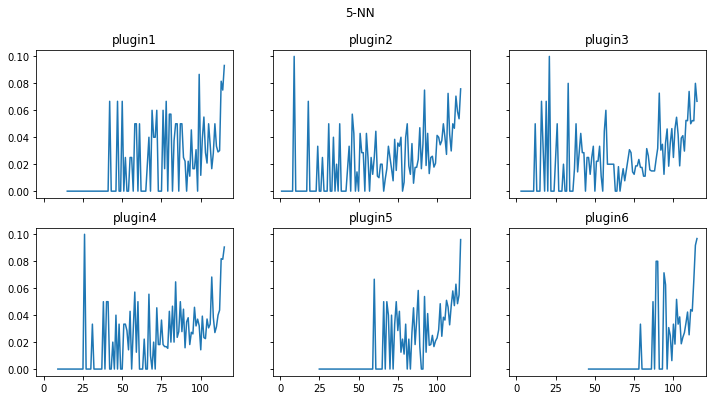

In [524]:
individual_accuracy(total, hits_kfolds_k5_mean, '5-NN')

# Quality of the recommendations by audio plugin category

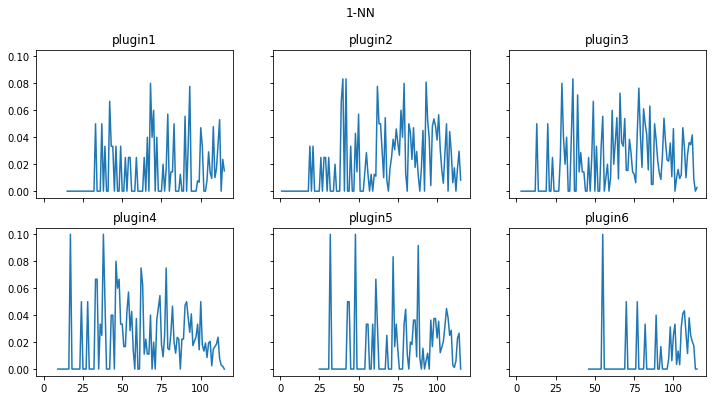

In [538]:
individual_accuracy(total, hits_kfolds_k1_category_mean, '1-NN')

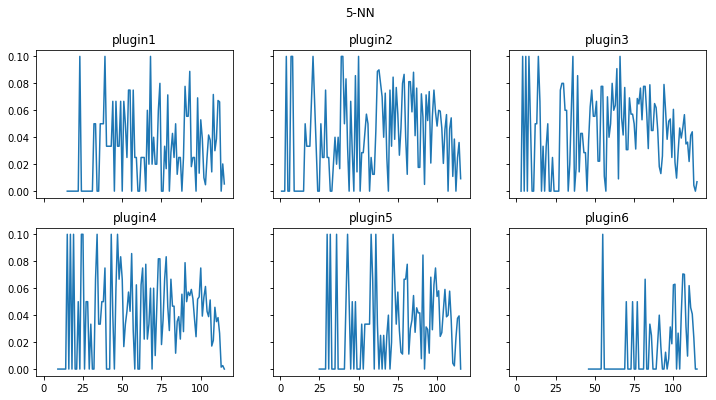

In [541]:
individual_accuracy(total, hits_kfolds_k5_category_mean, '5-NN')